### Import libraries

In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


### Dictionary to map class IDs to labels

In [2]:

labels = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road',
    24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits',
    33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left',
    38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory', 41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}


### Define Traffic Sign Dataset Class

In [3]:
class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, root_dir, meta_csv, meta_images_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.meta_data = pd.read_csv(meta_csv)
        self.meta_images_dir = meta_images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 7]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(self.data.iloc[idx, 6])
        
        row = self.meta_data.iloc[label]  
        shape_id = int(row['ShapeId'])
        color_id = int(row['ColorId'])
        
        sign_id = None  
        sign_id_str = str(row['SignId']).strip()
        if sign_id_str and sign_id_str != 'None':
            sign_id = float(sign_id_str.split('.')[0])
        else:
            sign_id = -1  
        
        meta_img_name = row['Path']
        meta_image = cv2.imread(meta_img_name)
        meta_image = cv2.cvtColor(meta_image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            meta_image = self.transform(meta_image)
        
        return image, label, shape_id, color_id, sign_id, meta_image


### Define TrafficSignNet Model

In [34]:
class TrafficSignNet(nn.Module):
    def __init__(self, num_classes=43, labels=None):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout_fc = nn.Dropout(0.5)
        self.labels = labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

    @torch.jit.export
    def get_class_label(self, class_id):
        return self.labels[class_id] if self.labels else "Unknown"

# Script the model
scripted_model = torch.jit.script(TrafficSignNet(num_classes=43, labels=labels))


In [35]:
def calculate_mean_std(dataset, device):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    for images, labels, shape_ids, color_ids, sign_ids, meta_images in loader:
        images = images.to(device)
        mean += images.mean([0, 2, 3])
        std += images.std([0, 2, 3])
    mean /= len(loader)
    std /= len(loader)
    return mean, std


### Evaluate the Model

In [36]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels, shape_ids, color_ids, sign_ids, meta_images in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    test_loss = running_loss / len(test_loader)
    return test_loss


### Define `train_model` Function

In [37]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=15, early_stopping_patience=5):
    train_loss_history = []
    test_loss_history = []
    best_test_loss = float('inf')
    no_improvement_counter = 0

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels, shape_ids, color_ids, sign_ids, meta_images in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        
        test_loss = evaluate_model(model, test_loader, criterion, device)
        test_loss_history.append(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        # Save the Model Checkpoint
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_counter = 0
            torch.save(model.state_dict(), 'best_traffic_sign_model.ckpt')
        else:
            no_improvement_counter += 1
        
        if no_improvement_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
        
        scheduler.step()

    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Define `test_model` function

In [38]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, shape_ids, color_ids, sign_ids, meta_images in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {100 * correct / total:.2f}%')


In [40]:
def convert_to_torchscript(model, device, filename='traffic_sign_model.pt'):
    model.eval()
    example_input = torch.rand(1, 3, 32, 32).to(device)
    traced_script_module = torch.jit.trace(model, example_input)
    traced_script_module.save(filename)


### Loading Datasets & Defining Image Transformations

In [41]:
# Data Paths
train_csv = 'csvs/Train.csv'
test_csv = 'csvs/Test.csv'
meta_csv = 'csvs/Meta.csv'
train_images_dir = 'Datasets/Train'
test_images_dir = 'Datasets/Test'
meta_images_dir = 'Datasets/Meta'

#Image Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [42]:
# Load Datasets
train_dataset = TrafficSignDataset(csv_file=train_csv, root_dir=train_images_dir, meta_csv=meta_csv, meta_images_dir=meta_images_dir, transform=transform)
test_dataset = TrafficSignDataset(csv_file=test_csv, root_dir=test_images_dir, meta_csv=meta_csv, meta_images_dir=meta_images_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Device and Instantiate Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficSignNet(num_classes=43, labels=labels).to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Execute train & test scripts

Epoch [1/15], Train Loss: 1.9049, Test Loss: 0.7607
Epoch [2/15], Train Loss: 0.6278, Test Loss: 0.3370
Epoch [3/15], Train Loss: 0.3618, Test Loss: 0.2559
Epoch [4/15], Train Loss: 0.2584, Test Loss: 0.2072
Epoch [5/15], Train Loss: 0.2098, Test Loss: 0.2119
Epoch [6/15], Train Loss: 0.1360, Test Loss: 0.1607
Epoch [7/15], Train Loss: 0.1163, Test Loss: 0.1578
Epoch [8/15], Train Loss: 0.1070, Test Loss: 0.1635
Epoch [9/15], Train Loss: 0.1020, Test Loss: 0.1587
Epoch [10/15], Train Loss: 0.0941, Test Loss: 0.1570
Epoch [11/15], Train Loss: 0.0902, Test Loss: 0.1546
Epoch [12/15], Train Loss: 0.0873, Test Loss: 0.1538
Epoch [13/15], Train Loss: 0.0867, Test Loss: 0.1529
Epoch [14/15], Train Loss: 0.0884, Test Loss: 0.1529
Epoch [15/15], Train Loss: 0.0842, Test Loss: 0.1536


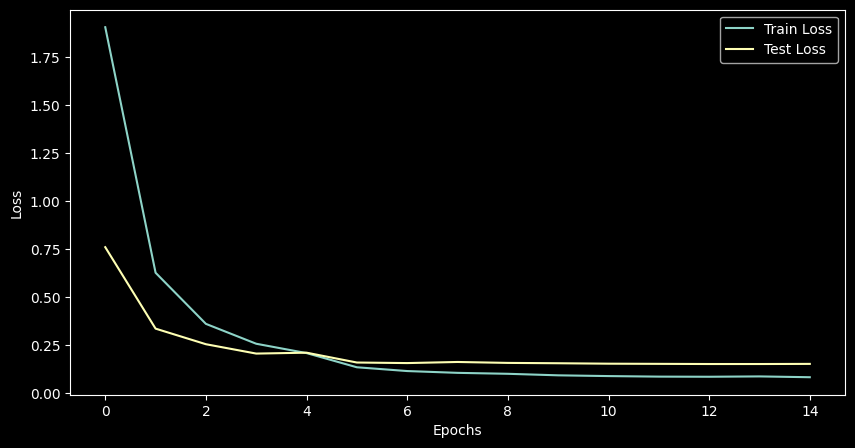

In [43]:
# executing training script
train_model(model, train_loader, criterion, optimizer, device, num_epochs=15, early_stopping_patience=5)


In [44]:
# executing test script
test_model(model, test_loader, device)


Test accuracy: 96.41%


### Generate sample predictions

In [39]:
def print_sample_predictions(model, test_loader, device, labels_dict, num_samples=10):
    sample_images, sample_labels, shape_ids, color_ids, sign_ids, meta_images = next(iter(test_loader))
    sample_images = sample_images.to(device)
    outputs = model(sample_images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()
    sample_labels = sample_labels.cpu().numpy()

    for i in range(num_samples):
        print(f'Predicted: {labels_dict[predicted[i]]}, Actual: {labels_dict[sample_labels[i]]}')


In [45]:
print_sample_predictions(model, test_loader, device, labels, num_samples=10)


Predicted: Vehicles over 3.5 metric tons prohibited, Actual: Vehicles over 3.5 metric tons prohibited
Predicted: Speed limit (30km/h), Actual: Speed limit (30km/h)
Predicted: Keep right, Actual: Keep right
Predicted: Turn right ahead, Actual: Turn right ahead
Predicted: Right-of-way at the next intersection, Actual: Right-of-way at the next intersection
Predicted: Keep right, Actual: Keep right
Predicted: General caution, Actual: General caution
Predicted: Priority road, Actual: Priority road
Predicted: Road work, Actual: Road work
Predicted: Ahead only, Actual: Ahead only


### Loading the checkpoints & saving torch script file

In [46]:
model.load_state_dict(torch.load('best_traffic_sign_model.ckpt'))
convert_to_torchscript(model, device, filename='traffic_sign_model.pt')


<All keys matched successfully>